# Explore AMI corpus for speaker diarization

In this notebook, the characteristics of the [AMI](https://groups.inf.ed.ac.uk/ami/corpus/overview.shtml) corpus will be analyzed to see whether it is adequate for comparing different speaker diarization [pipelines](https://hackmd.io/xr3m0hiWRLeh9TzYlMNAeA). The comparison requires the corpus to have many segments of speech and non-speech with differing lengths. The speech segments should be distributed equally across speakers. The corpus includes four different speakers per file (differing across files).

In [14]:
from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ami = load_dataset("ami", "microphone-single", split=["test"])[0]

Reusing dataset ami (C:\Users\MalteLuken\.cache\huggingface\datasets\ami\microphone-single\1.6.2\2accdf810f7c0585f78f4bcfa47684fbb980e35d29ecf126e6906dbecb872d9e)
100%|██████████| 1/1 [00:00<00:00, 250.45it/s]


In [3]:
def get_sample_length(sample):
    audio = sample["audio"]
    return audio["array"].shape[0]/audio["sampling_rate"]

In [4]:
def get_nr_segments(sample):
    return len(sample["segment_ids"]) + 1

In [5]:
def get_non_speech_ratio(sample):
    inter_segment_lengths = []
    for i, _ in enumerate(sample["segment_ids"]):
        if i < len(sample["segment_ids"])-1 and sample["segment_start_times"][i+1]>=sample["segment_end_times"][i]:
            inter_segment_lengths.append(sample["segment_start_times"][i+1]-sample["segment_end_times"][i])
    total_length = np.sum(inter_segment_lengths)
    non_speech_ratio = total_length/get_sample_length(sample)
    return non_speech_ratio

In [6]:
def get_segment_lengths(sample):
    return np.array(sample["segment_end_times"]) - np.array(sample["segment_start_times"])

In [7]:
def get_segment_stats(sample):
    segment_lengths = get_segment_lengths(sample)
    return round(np.mean(segment_lengths), 2), round(np.std(segment_lengths), 2), round(np.min(segment_lengths), 2), round(np.max(segment_lengths), 2)

In [8]:
def get_equal_speakers_index(sample):
    spks = list(set(sample["segment_speakers"]))
    prob = np.array([sample["segment_speakers"].count(spk) for spk in spks])/get_nr_segments(sample)
    sh_index = -np.sum(prob*np.log(prob))
    rndm = np.array([0.25, 0.25, 0.25, 0.25])
    return sh_index/-np.sum(rndm*np.log(rndm))

In [9]:
def get_equal_speech_time_index(sample):
    segment_lengths = get_segment_lengths(sample)
    spks = list(set(sample["segment_speakers"]))
    spk_times = []
    for spk in spks:
        spk_times.append(np.sum([segment_lengths[i] for i, ref_spk in enumerate(sample["segment_speakers"]) if ref_spk == spk]))
    
    sample_length = get_sample_length(sample)
    rel_spk_times = np.array(spk_times)/sample_length
    sh_index = -np.sum(rel_spk_times*np.log(rel_spk_times))
    rndm = np.array([0.25, 0.25, 0.25, 0.25])
    return sh_index/-np.sum(rndm*np.log(rndm))

In [10]:
df_dict = {'sample_length_min': [], 'nr_segments': [], 'seg_length_secs_M_SD_Min_Max': [], 'non_speech_ratio': [], 'equal_speakers_index': [], 'equal_speech_time_index': []}

for row in ami:
    df_dict['sample_length_min'].append(get_sample_length(row)/60)
    df_dict['nr_segments'].append(get_nr_segments(row))
    df_dict['seg_length_secs_M_SD_Min_Max'].append(get_segment_stats(row))
    df_dict['non_speech_ratio'].append(get_non_speech_ratio(row))
    df_dict['equal_speakers_index'].append(get_equal_speakers_index(row))
    df_dict['equal_speech_time_index'].append(get_equal_speech_time_index(row))

In [11]:
pd.DataFrame(df_dict).round(2)

,sample_length_min,nr_segments,seg_length_secs_M_SD_Min_Max,non_speech_ratio,equal_speakers_index,equal_speech_time_index
0,17.49,284,"(3.72, 5.77, 0.27, 43.44)",0.45,0.97,0.93
1,39.09,488,"(4.94, 8.28, 0.27, 59.36)",0.41,0.99,0.98
2,38.91,522,"(4.68, 7.13, 0.29, 42.93)",0.42,0.99,0.98
3,37.04,668,"(3.39, 5.88, 0.3, 55.06)",0.49,1.00,0.96
4,13.98,223,"(3.48, 4.85, 0.19, 31.58)",0.38,0.97,0.81
5,34.21,410,"(5.07, 10.3, 0.27, 58.61)",0.49,0.99,0.99
6,30.35,334,"(5.05, 10.08, 0.21, 128.4)",0.40,0.98,0.95
7,32.41,538,"(3.52, 5.85, 0.19, 48.68)",0.37,0.99,0.90
8,25.09,310,"(3.91, 7.61, 0.22, 56.22)",0.50,0.93,0.59
9,36.84,440,"(4.58, 5.76, 0.22, 27.58)",0.25,0.91,0.89


In [12]:
segment_lengths = []

for row in ami:
    for seg_len in get_segment_lengths(row):
        if seg_len < 60: # Only less than 1 min
            segment_lengths.append(seg_len)

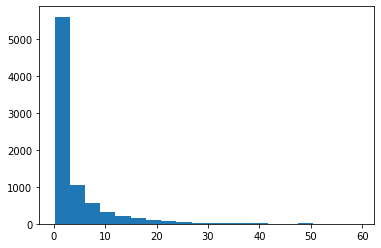

In [13]:
fig, ax = plt.subplots(1, 1)

ax.hist(segment_lengths, bins=20)

plt.show()

The corpus contains multiple files with differing numbers of speech segments. The segments have different lengths ranging from less than a second (probably hard to identify the speaker) to two minutes (easy to identify) of speech. All files contain a sufficient amount of speech and non-speech to test voice activity detection components of the pipelines. The equal speakers index gives the entropy of the multinomial speaker distribution relative to a distribution with all speakers speaking an equal amount of segments. The closer to 1 the index is, the more equally segments are distributed across speakers. This does not take into account the length of the segments, however, a short subset of a segment (5-10 secs) is usually sufficient to identify the speaker. Thus, it is more important to have equally distributed segments rather than equally distributed speaking times. In contrast, the equal speech time index is closer to one if the speakers speak an equal amount of time taken all segments together (it is sometimes larger than 1 because of overlapping segments). Both indices are close to 1 for most files, indicating that the dataset is fit for comparison.